In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pokemon/Pokemon.csv


In [3]:
%matplotlib inline
init_notebook_mode(connected=True)
sns.set_style('whitegrid')

In [4]:
pokemon = pd.read_csv('../input/pokemon/Pokemon.csv')

In [5]:
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [6]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
#             800 non-null int64
Name          800 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
Total         800 non-null int64
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Type 2 is having null data. If you are a Pokemon fan, you know that not every pokemon have 2 types, so it's normal

In [7]:
pokemon['Legendary'].value_counts()

False    735
True      65
Name: Legendary, dtype: int64

There are 65 Legendary Pokemon from Gen 1 to Gen 6.
OMG, I thought the number is only about 20. The last pokemon game I play was gen 3. I have no Idea about Gen 4 5 6

In [8]:
pokemon.groupby(['Generation','Legendary']).count()['Name']

Generation  Legendary
1           False        160
            True           6
2           False        101
            True           5
3           False        142
            True          18
4           False        108
            True          13
5           False        150
            True          15
6           False         74
            True           8
Name: Name, dtype: int64

Okay, Gen 3 has the most legendary pokemon, and in gen 4 5 6, total legend pokemon dramatically increase (Why the heck did you do that Nintendo?)

In [9]:
pokemon[pokemon['Legendary']]['Type 2'].isnull().value_counts()

False    40
True     25
Name: Type 2, dtype: int64

Legendary Pokemons often have 2 Types (yess, they are Legends)

Let transform the data of Legendary column to number so that we can visualize it.

In [10]:
Legend = pd.get_dummies(pokemon['Legendary'],drop_first=True)

In [11]:
pokemon.drop(['#','Legendary'],axis=1,inplace=True)

In [12]:
pokemon = pd.concat([pokemon,Legend],axis=1)
pokemon.rename({True:'Legend'},axis=1, inplace=True)

In [13]:
pokemon.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legend
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,0


First, use pairplot to view the correlation

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



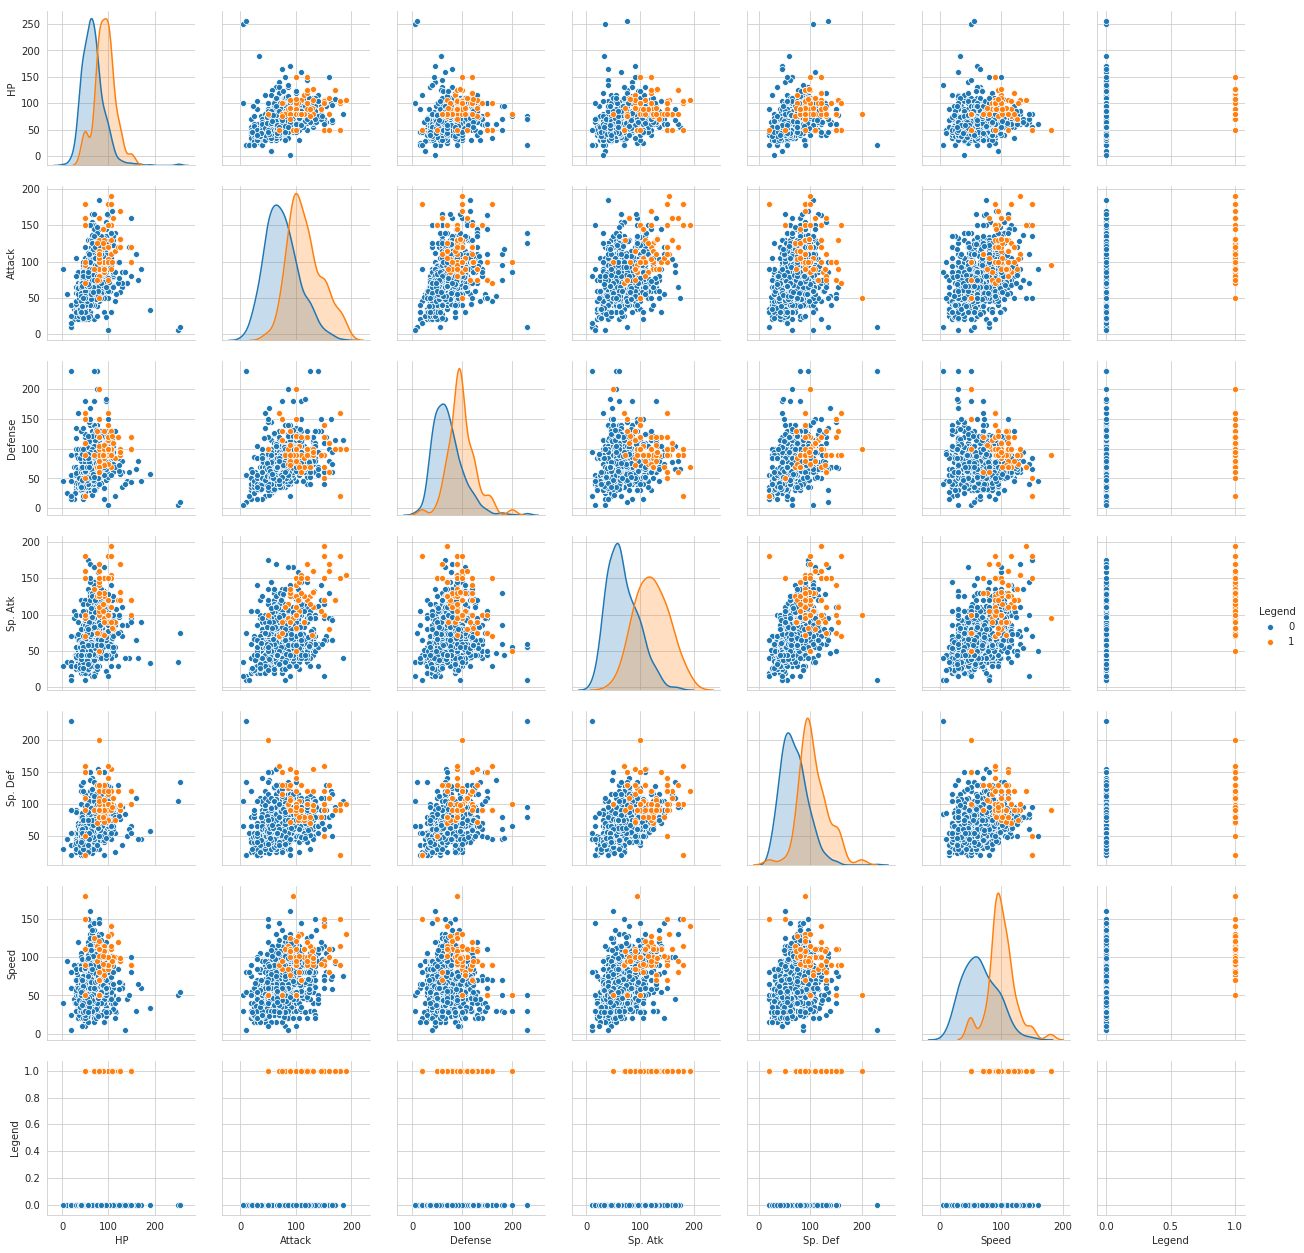

In [14]:
g=sns.pairplot(pokemon[['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Legend']],hue='Legend')

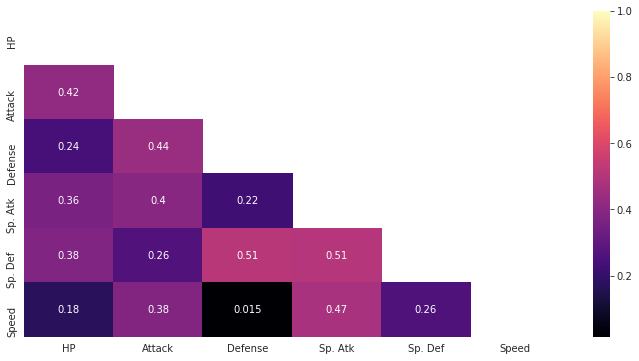

In [15]:
corr = pokemon[['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed']].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12,6))
sns.heatmap(corr,mask=mask,cmap='magma',annot=True)

* Special Defence is related to Defense and Special Attack!! 
* Attack and Deffence also have correlation

Let see top 10 strongest pokemon

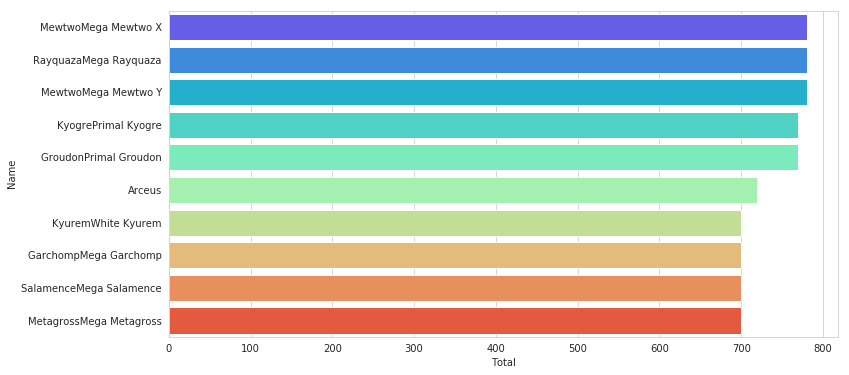

In [16]:
plt.figure(figsize=(12,6))
sns.barplot(y='Name',x='Total', 
            data=pokemon.iloc[pokemon['Total'].sort_values(ascending=False)[:10].index], 
            palette="rainbow")

Wow, Mewtwo is really strong, maybe the strongest Pkm so far. And you can clearly see that with Megaevolution, Nintendo boosted the total stats of Pokemon

Top 10 Pokemon have biggest Special Attack

In [17]:
df = pokemon.iloc[pokemon['Sp. Atk'].sort_values(ascending=False)[:10].index]
fig = px.bar(df, x='Sp. Atk', y='Name', orientation='h',color='Legend',
            category_orders={'Name': df['Name'].tolist()})
fig.show()

Mewtwo again. Most of strong pkms are Legendary

Top 10 Pokemon have biggest Attack

In [18]:
df = pokemon.iloc[pokemon['Attack'].sort_values(ascending=False)[:10].index]
fig = px.bar(df, x='Attack', y='Name', orientation='h',color='Generation',
            category_orders={'Name': df['Name'].tolist()})
fig.show()

Generation 3 have outstanding pokemons the most. Imbalance generation  

OK, Let go to compare 2 pokemons based on Attack Defense and HP Speed.

In [19]:
def pokeplot(pokemon1,pokemon2,stat1,stat2):
    f = sns.FacetGrid(pokemon[(pokemon['Generation'].apply(lambda x: x in [1,2,3,4,5,6]))], hue='Legend', size=8) \
       .map(plt.scatter, stat1, stat2, alpha=0.5) \
       .add_legend()
    plt.subplots_adjust(top=0.9)
    f.fig.suptitle('{} vs. {}'.format(stat1, stat2))
    f.ax.set_xlim(0,)
    f.ax.set_ylim(0,)
    
    pkm1 = pokemon[pokemon['Name'] == pokemon1]
    pkm2 = pokemon[pokemon['Name'] == pokemon2]
    
    plt.scatter(pkm1[stat1],pkm1[stat2],s=100,marker='x', c='#d400ff')
    plt.text(pkm1[stat1]+3,pkm1[stat2]-6, pokemon1, 
             fontsize=13, weight='bold', color='#d400ff')
    
    plt.scatter(pkm2[stat1],pkm2[stat2],s=100,marker='x', c='#ff0000')
    plt.text(pkm2[stat1]+3,pkm2[stat2]-6, pokemon2, 
             fontsize=13, weight='bold', color='#ff0000')

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



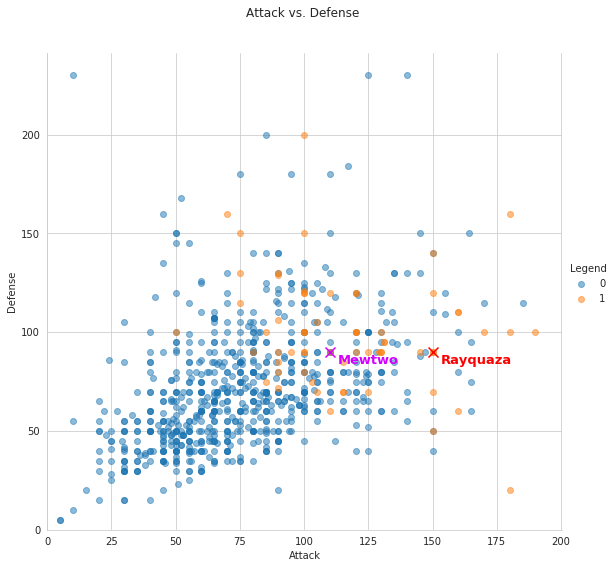

In [20]:
pokeplot('Mewtwo','Rayquaza','Attack','Defense')

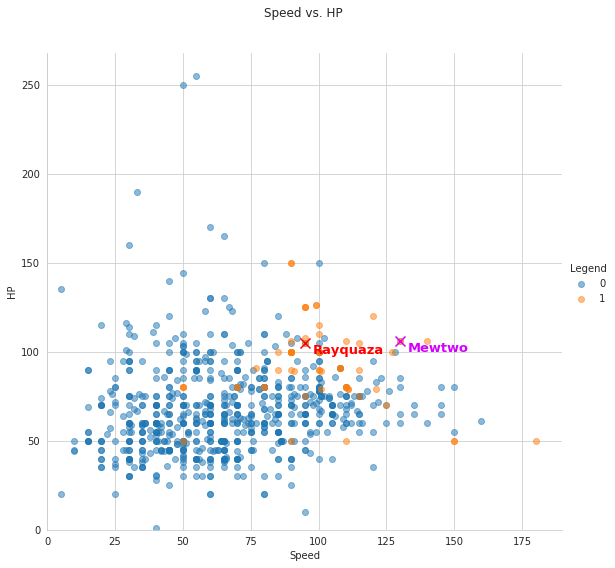

In [21]:
pokeplot('Mewtwo','Rayquaza','Speed','HP')

# Predict whether a pokemon is legendary base on stats (Basic ML)


1. Go to check the data and clean it

First, we need to convert Type to number, and if Type= null make it to 0

In [22]:
def type_numbering(string) : 
    if string == 'Normal' :
        return 1
    elif string== 'Fire' :
        return 2
    elif string == 'Fighting' :
        return 3
    elif string == 'Water' :
        return 4
    elif string == 'Flying' :
        return 5
    elif string == 'Grass' :
        return 6
    elif string == 'Poison' :
        return 7
    elif string == 'Electric' :
        return 8
    elif string == 'Ground' :
        return 9
    elif string == 'Psychic' :
        return 10
    elif string == 'Rock' :
        return 11
    elif string == 'Ice' :
        return 12
    elif string == 'Bug' :
        return 13
    elif string == 'Dragon' :
        return 14
    elif string == 'Ghost' :
        return 15
    elif string == 'Dark' :
        return 16
    elif string == 'Steel' :
        return 17
    elif string == 'Fairy' :
        return 18
    else :
        return 0

In [23]:
pokemon['Type 1'] = pokemon['Type 1'].apply(type_numbering)
pokemon['Type 2'] = pokemon['Type 2'].apply(type_numbering)

In [24]:
pokemon.drop('Name',axis=1,inplace=True)

2. Create data for training and testing by using Train Test Split

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X= pokemon.drop('Legend',axis=1)
y= pokemon['Legend']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

3. Using model

In [27]:
from sklearn.metrics import confusion_matrix,classification_report

**Logistic Regression**

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
logmode = LogisticRegression()

In [30]:
logmode.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
y_pred = logmode.predict(X_test)

In [32]:
cm = pd.DataFrame(confusion_matrix(y_test,y_pred), 
                  index = ['Non-Legendary', 'Legendary'], columns = ['Non-Legendary', 'Legendary'])
cm.index.name = 'Actual'
cm.columns.name = 'Predict'
print(cm)

Predict        Non-Legendary  Legendary
Actual                                 
Non-Legendary            215          1
Legendary                 19          5


In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       216
           1       0.83      0.21      0.33        24

    accuracy                           0.92       240
   macro avg       0.88      0.60      0.64       240
weighted avg       0.91      0.92      0.89       240



**Decision Tree**

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
dtc = DecisionTreeClassifier(max_depth=5)

In [36]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [37]:
y_pred2 = dtc.predict(X_test)

In [38]:
cm = pd.DataFrame(confusion_matrix(y_test,y_pred2), 
                  index = ['Non-Legendary', 'Legendary'], columns = ['Non-Legendary', 'Legendary'])
cm.index.name = 'Actual'
cm.columns.name = 'Predict'
print(cm)

Predict        Non-Legendary  Legendary
Actual                                 
Non-Legendary            210          6
Legendary                  7         17


In [39]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       216
           1       0.74      0.71      0.72        24

    accuracy                           0.95       240
   macro avg       0.85      0.84      0.85       240
weighted avg       0.94      0.95      0.95       240



**Random Forest**

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rfc= RandomForestClassifier(max_depth=5)

In [42]:
rfc.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
y_pred3 = rfc.predict(X_test)

In [44]:
cm = pd.DataFrame(confusion_matrix(y_test,y_pred3), 
                  index = ['Non-Legendary', 'Legendary'], columns = ['Non-Legendary', 'Legendary'])
cm.index.name = 'Actual'
cm.columns.name = 'Predict'
print(cm)

Predict        Non-Legendary  Legendary
Actual                                 
Non-Legendary            212          4
Legendary                 15          9


In [45]:
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       216
           1       0.69      0.38      0.49        24

    accuracy                           0.92       240
   macro avg       0.81      0.68      0.72       240
weighted avg       0.91      0.92      0.91       240



**Support Vecter Machines**

In [46]:
from sklearn.svm import SVC

In [47]:
svc= SVC()

In [48]:
from sklearn.model_selection import GridSearchCV
params = {'C':[0.1, 1, 10, 100, 1000],'gamma':[1, 0.1, .01, .001, .0001]}
grid = GridSearchCV(estimator=svc, param_grid=params,refit=True,verbose=2)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.1 ................................................


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................. C=0.1, gamma=0.1, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total=   0.0s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total=   0.0s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............................... C=0.1, gamma=0.001, total=   0.0s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............................... C=0.1, gamma=0.001, total=   0.0s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............................... C=0.1, gamma=0.001, total=   0.0s
[CV] C=0.1, gamma=0.0001 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [49]:
print(grid.best_score_)
print(grid.best_params_)

0.9464285714285714
{'C': 1, 'gamma': 0.0001}


In [50]:
pred_g = grid.predict(X_test)

In [51]:
cm = pd.DataFrame(confusion_matrix(y_test,pred_g), 
                  index = ['Non-Legendary', 'Legendary'], columns = ['Non-Legendary', 'Legendary'])
cm.index.name = 'Actual'
cm.columns.name = 'Predict'
print(cm)

Predict        Non-Legendary  Legendary
Actual                                 
Non-Legendary            214          2
Legendary                 17          7


In [52]:
print(classification_report(y_test,pred_g))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       216
           1       0.78      0.29      0.42        24

    accuracy                           0.92       240
   macro avg       0.85      0.64      0.69       240
weighted avg       0.91      0.92      0.90       240



Thank you so much